In [1]:
import yaml
import matplotlib.pyplot as plt
from lvmsurveysim import IFU, Telescope
from lvmsurveysim.schedule import ObservingPlan, Simulator, TileDB
from lvmsurveysim.target import Target, TargetList
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import PercentileInterval, SqrtStretch, ImageNormalize
from astropy import units as u
from regions import PixCoord, PolygonSkyRegion

In [2]:
with open('./trifid.yaml', 'r') as f:
    tgt = yaml.safe_load(f)
tgt

{'Trifid': {'coords': [6.6, -0.3],
  'region_type': 'rectangle',
  'frame': 'galactic',
  'region_params': {'width': 0.9, 'height': 0.75, 'pa': 150},
  'priority': 9,
  'observatory': 'LCO',
  'telescope': 'LVM-160',
  'max_airmass': 1.75,
  'min_shadowheight': 1000.0,
  'exptime': 900,
  'n_exposures': 1,
  'min_exposures': 1,
  'min_moon_dist': 60,
  'max_lunation': 1.0,
  'overhead': 1.1,
  'tiling_strategy': 'lowest_airmass',
  'tile_overlap': 0.1}}

In [3]:
xctr,yctr = tgt['Trifid']['coords']
print(xctr,yctr)

6.6 -0.3


In [4]:
targets = TargetList(target_file='./trifid.yaml')
print('Tiling Survey ...')
tiledb = TileDB(targets)
tiledb.tile_targets()
tiledb.tile_table.write('trifid_tiles.fits', format='fits', overwrite=True)

Tiling Survey ...
Tiling target Trifid


In [5]:
tbl = tiledb.tile_table
tbl

TileID,TargetIndex,Target,Telescope,RA,DEC,PA,TargetPriority,TilePriority,AirmassLimit,LunationLimit,HzLimit,MoonDistanceLimit,TotalExptime,VisitExptime,Status
int64,int64,str6,str7,float64,float64,float64,int64,int64,float64,float64,float64,int64,int64,int64,int64
1000001,0,Trifid,LVM-160,270.63010356450627,-23.38286892553824,659.561789588583,9,1,1.75,1.0,1000.0,60,900,900,0
1000002,0,Trifid,LVM-160,270.2580340207353,-23.582797037029483,299.70971935292624,9,1,1.75,1.0,1000.0,60,900,900,0
1000003,0,Trifid,LVM-160,270.6268195758288,-22.987373588031726,659.5634135547286,9,1,1.75,1.0,1000.0,60,900,900,0
1000004,0,Trifid,LVM-160,270.25585106725487,-23.187296031394965,659.7097346388199,9,1,1.75,1.0,1000.0,60,900,900,0
1000005,0,Trifid,LVM-160,269.8837716800428,-23.386333631905238,299.8588643152909,9,1,1.75,1.0,1000.0,60,900,900,0


In [6]:
ifu = IFU.from_config()
lvm160 = Telescope.from_config('LVM-160')

In [7]:
lvm160.plate_scale

<Quantity 348.42060811 arcsec / mm>

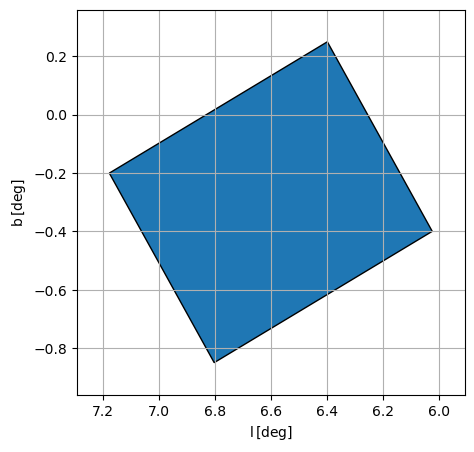

In [8]:
trif = Target.from_list('Trifid',targets=tgt)
fig, ax = trif.plot()
fig.set_figheight(5)
fig.set_figwidth(5)
ax.invert_xaxis()

In [9]:
ras  = trif.region.vertices().T[0]
decs = trif.region.vertices().T[1]
print(ras)
print(decs)
vertices = SkyCoord(ras, decs, unit='deg', frame='galactic')
trif_skyreg = PolygonSkyRegion(vertices=vertices)

[7.17721496 7.10221977 7.0272252  6.9522301  6.87723331 6.80223367
 6.64633093 6.4904348  6.33454412 6.17865775 6.02277452 6.097783
 6.17278729 6.24778856 6.32278796 6.39778665 6.55367296 6.70955779
 6.8654423  7.02132764 7.17721496]
[-0.20024047 -0.33014428 -0.46004809 -0.58995191 -0.71985572 -0.84975953
 -0.75975953 -0.66975953 -0.57975953 -0.48975953 -0.39975953 -0.26985572
 -0.13995191 -0.01004809  0.11985572  0.24975953  0.15975953  0.06975953
 -0.02024047 -0.11024047 -0.20024047]


In [10]:
# Load SHASSA image
dat, hdr = fits.getdata('153.fl.fits.gz', header=True)
wcs = WCS(hdr)
print(dat.shape)

(998, 1014)


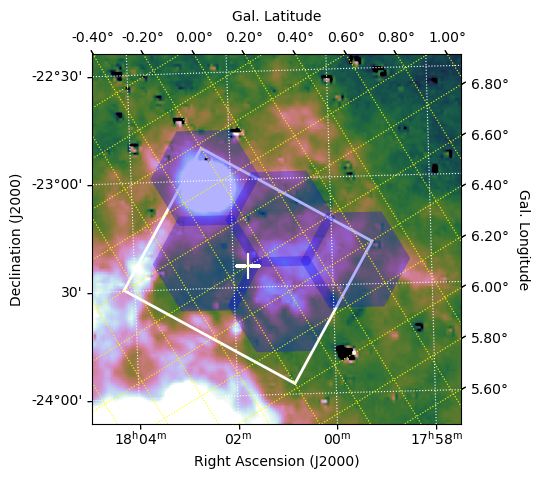

In [11]:
ax = plt.subplot(projection=wcs)
norm = ImageNormalize(dat, interval=PercentileInterval(98),
                      stretch=SqrtStretch())
ax.imshow(dat, origin='lower', cmap='cubehelix', norm=norm)
trif_skyreg.to_pixel(wcs).plot(ax=ax, color='w', lw=2.0)
overlay = ax.get_coords_overlay('galactic')
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')
ax.coords[0].set_ticks_position('b')
ax.coords[1].set_ticks_position('l')
ax.grid(color='white', ls=':')
overlay.grid(color='yellow', ls=':')
overlay['l'].set_axislabel('Gal. Longitude')
overlay['l'].set_major_formatter('d.dd')
overlay['l'].set_ticks(spacing=0.2 * u.deg)
overlay['l'].set_ticks_position('r')
overlay['l'].set_ticklabel_position('r')
overlay['l'].set_axislabel_position('r')
overlay['b'].set_axislabel('Gal. Latitude')
overlay['b'].set_major_formatter('d.dd')
overlay['b'].set_ticks(spacing=0.2 * u.deg)
overlay['b'].set_ticks_position('t')
overlay['b'].set_ticklabel_position('t')
overlay['b'].set_axislabel_position('t')
ax.set_xlim(700, 830)
ax.set_ylim(160, 290)
for p in tbl:
    patch = ifu.get_patch(scale=lvm160.plate_scale, centre=[p['RA'], p['DEC']], pa=p['PA'],
                            edgecolor='None', linewidth=0.0, alpha=0.3, facecolor='b',
                            transform=ax.get_transform('fk5'))[0]
    ax.add_patch(patch)
# Coordinates given in Google form
# c0 = SkyCoord('18h02m31.384s', '-22d57m57.6s')
# ax.scatter(c0.ra.deg, c0.dec.deg, transform=ax.get_transform('fk5'), s=300, 
#            marker=(5,2), facecolor='white')
# c1 = SkyCoord('18h01m', '-23d17m')
# ax.scatter(c1.ra.deg, c1.dec.deg, transform=ax.get_transform('fk5'), s=300, 
#            marker=(5,2), facecolor='white')
c2 = SkyCoord(xctr, yctr, frame='galactic', unit='deg')
ax.scatter(c2.l.deg, c2.b.deg, transform=ax.get_transform('galactic'), s=300, 
           marker=(4,2), facecolor='white')